In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ..

/home/pierre/git/bo-on-graph


# Synthetic Experiments
- BA graph ws grid: 100 nodes
- all the kernels
- Plot r-1
- Plot validation error plot

In [7]:
# test the GP cross validation
from problems import get_synthetic_problem
import torch
from search.trust_region import (
    restart,
)
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from search.utils import eigendecompose_laplacian
from search.models import initialize_model
from scipy.stats import spearmanr
from tqdm._tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [17]:

def plot_signal(ax_signal, base_problem, all_Y, pos, y_label="Smooth signal Grid graph"):
    g = base_problem.context_graph
    nodes = base_problem.context_graph.nodes()
    node_size=50
    nx.draw_networkx(base_problem.context_graph, pos, with_labels=False, ax = ax_signal, node_size=node_size)
    #nc = nx.draw_networkx_nodes(g, pos, nodelist=nodes, node_color=all_Y, node_size=100, cmap=plt.cm.jet, ax = ax_signal)
    nc = nx.draw_networkx_nodes(g, pos, nodelist=nodes, node_color=all_Y, node_size=node_size, cmap=mpl.colormaps['Greens'], ax = ax_signal)
    plt.colorbar(nc, ax=ax_signal)
    ax_signal.set_axis_off()
    ax_signal.set_ylabel(y_label)

def output_model(covar_type, X_train, Y_train, base_problem):
    #covar_type = "diffusion"
    #covar_type = "polynomial"
    #covar_type = "polynomial_old"
    #covar_type = "diffusion"
    #covar_type = "diffusion_ard"
    if covar_type in ["polynomial", "polynomial_old"]:
        order = None
        model, mll, cached_eigenbasis = initialize_model(
                    train_X=X_train,
                    train_Y=Y_train,
                    context_graph=base_problem.context_graph,
                    covar_type=covar_type,
                    covar_kwargs = {
                        "order": order,
                        },
                    fit_model=True,
                    ard=True,
                    use_fixed_noise=False,
                    optim_kwargs = {
                        "train_iters": 1500,
                        "lr": .1
                    },
                    use_saas_map=False
                    )
    elif covar_type == "diffusion":
        order = None
        model, mll, cached_eigenbasis = initialize_model(
                    train_X=X_train,
                    train_Y=Y_train,
                    context_graph=base_problem.context_graph,
                    covar_type=covar_type,
                    covar_kwargs = {
                        "order": order,
                        },
                    fit_model=True,
                    ard=False,
                    use_fixed_noise=False,
                    optim_kwargs = {
                        "train_iters": 1500,
                        "lr": .1
                    },
                    use_saas_map=False
                    )
    elif covar_type == "diffusion_ard":
        order = None
        model, mll, cached_eigenbasis = initialize_model(
                    train_X=X_train,
                    train_Y=Y_train,
                    context_graph=base_problem.context_graph,
                    covar_type="diffusion",
                    covar_kwargs = {
                        "order": None,
                        },
                    fit_model=True,
                    ard=True,
                    use_fixed_noise=False,
                    optim_kwargs = {
                        "train_iters": 1500,
                        "lr": .1
                    },
                    use_saas_map=False
                    )
    return model, mll, cached_eigenbasis

def plot_validation(ax_kernel, model, X_test, Y_test, title = "Polynomial"):
    model.eval()
    with torch.no_grad():
        # predict on train input
        Y_test_pred = model.posterior(X_test)
        Y_test_pred_mean, Y_test_pred_std = Y_test_pred.mean.flatten(), torch.sqrt(Y_test_pred.variance).flatten()
        ax_kernel.plot(Y_test, Y_test_pred_mean, ".")
        ax_kernel.errorbar(Y_test, Y_test_pred_mean, yerr=Y_test_pred_std, linestyle="None", color="C0", alpha=0.3)
        ax_kernel.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], color="gray", linestyle='--')
        #ax_kernel.text(0,0,f"r: {spearmanr(Y_test_pred_mean, Y_test)}")
        ax_kernel.set_xlabel("Validation ground truth")
        ax_kernel.set_title(title)

def plot_rinverse(ax_kernel, model):
    ax_kernel.plot(model.covar_module.base_kernel.eigenvalues.detach(), torch.diag(model.covar_module.base_kernel.get_dist()).detach())
    ax_kernel.ticklabel_format(style='sci', scilimits=(-1,1))

In [9]:
### Define graph
n = 200
base_problem = get_synthetic_problem(
    "test_function", 
    n=n, 
    seed=0,
    problem_kwargs={
        "log": False, 
        "random_graph_type": "grid",
        #"m": 2,
        "n": n,
        "test_function": "sphere"
        }
    )

X_train = torch.empty(0,1)
Y_train = torch.empty(0,1)
base_model, base_mll, based_cached_eigenbasis = initialize_model(
                train_X=X_train,
                train_Y=Y_train,
                context_graph=base_problem.context_graph,
                covar_type="diffusion",
                covar_kwargs = {
                    "order": 1,
                     },
                fit_model=False,
                ard=True,
                use_fixed_noise=False,
                use_saas_map=False
                )

pos = nx.kamada_kawai_layout(base_problem.context_graph)

<class 'networkx.utils.decorators.argmap'> compilation 12:4: FutureWarning: normalized_laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
/home/pierre/miniconda3/envs/graph/lib/python3.10/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)


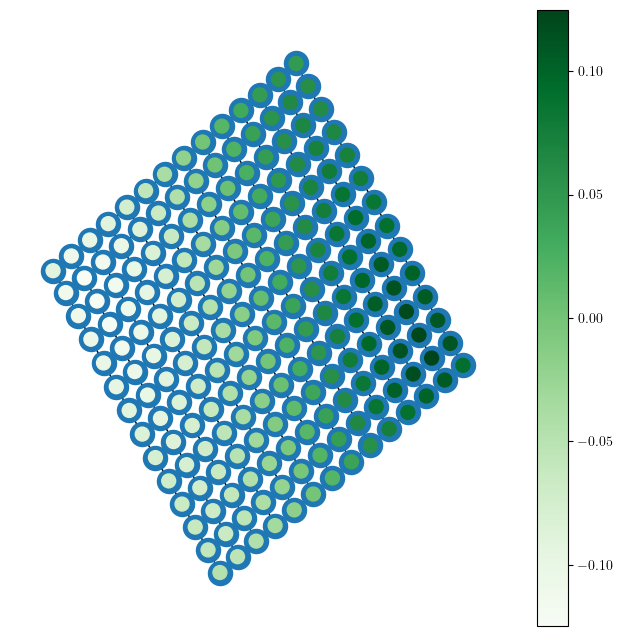

In [12]:
# Define signal
def get_signal(base_model, j=2):
    prop_data = 0.5
    all_X = torch.arange(len(base_problem.context_graph)).to(torch.float)
    all_Y = base_model.covar_module.base_kernel.eigenbasis[:,j].detach().clone()
    #all_Y = base_problem(all_X.reshape(-1, 1))

    from botorch.utils.transforms import standardize
    n_init = len(all_X)
    X = all_X.reshape(-1, 1).detach().clone()

    # Y = base_problem(X.reshape(-1, 1))
    Y = all_Y.reshape(-1, 1).to(dtype=torch.float).detach().clone()
    Y = standardize(Y)

    best_loc = Y.argmax().item()
    X_best = X[best_loc]

    n_train = int(n_init * prop_data)
    ntrain_indices = np.random.choice(n_init, n_train, replace=False)
    ntest_indices = np.array([i for i in range(n_init) if i not in ntrain_indices])
    X_train, Y_train = X[ntrain_indices, ...], Y[ntrain_indices]
    X_test, Y_test = X[ntest_indices, ...], Y[ntest_indices, ...]
    pos = nx.kamada_kawai_layout(base_problem.context_graph)
    return all_X, all_Y, X_train, Y_train, X_test, Y_test, X_best

all_X, all_Y, X_train, Y_train, X_test, Y_test, X_best = get_signal(base_model, j=2)

# all_Y = eigenvecs[:, 0]
g = base_problem.context_graph
nodes = base_problem.context_graph.nodes()
colors = all_Y
plt.figure(figsize=[8, 8])
nx.draw_networkx(base_problem.context_graph, pos, with_labels=False)
ec = nx.draw_networkx_edges(g, pos, alpha=0.2, )
#nc = nx.draw_networkx_nodes(g, pos, nodelist=nodes, node_color=colors, node_size=100, cmap=plt.cm.jet)
nc = nx.draw_networkx_nodes(g, pos, nodelist=nodes, node_color=colors, node_size=100, cmap=mpl.colormaps['Greens'])

plt.colorbar(nc)
plt.axis('off')
plt.show()

<class 'networkx.utils.decorators.argmap'> compilation 12:4: FutureWarning: normalized_laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
/home/pierre/miniconda3/envs/graph/lib/python3.10/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
/home/pierre/miniconda3/envs/graph/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/pierre/miniconda3/envs/graph/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1

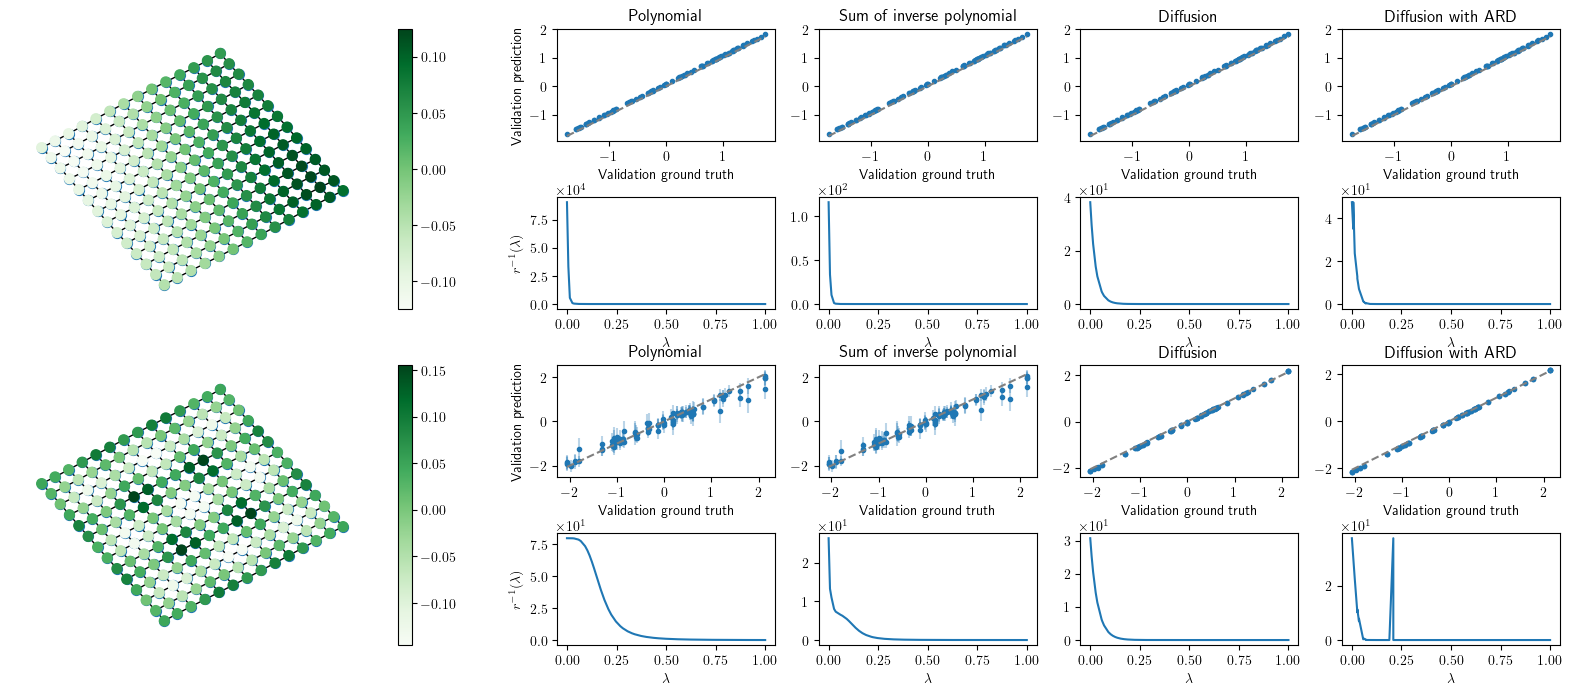

In [18]:
plt.rcParams['text.usetex'] = True

fig = plt.figure(figsize=(20, 8), layout='constrained')
grid = plt.GridSpec(2, 3, hspace=0., wspace=0.2)



signal_ax = fig.add_subplot(grid[:, 0])
signal_ax.set_axis_off()
kernel_subplot = fig.add_subplot(grid[:, 1:])
kernel_subplot.set_axis_off()

inner_signal = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=signal_ax, wspace=0., hspace=0.2)
inner_kernel = gridspec.GridSpecFromSubplotSpec(4, 4, subplot_spec=kernel_subplot, wspace=0.2, hspace=0.5)

signal1_ax = plt.Subplot(fig, inner_signal[0])
signal2_ax = plt.Subplot(fig, inner_signal[1])

kernel11v_ax = plt.Subplot(fig, inner_kernel[0, 0])
kernel12v_ax = plt.Subplot(fig, inner_kernel[0, 1])
kernel13v_ax = plt.Subplot(fig, inner_kernel[0, 2])
kernel14v_ax = plt.Subplot(fig, inner_kernel[0, 3])

kernel11r_ax = plt.Subplot(fig, inner_kernel[1, 0])
kernel12r_ax = plt.Subplot(fig, inner_kernel[1, 1])
kernel13r_ax = plt.Subplot(fig, inner_kernel[1, 2])
kernel14r_ax = plt.Subplot(fig, inner_kernel[1, 3])

kernel21v_ax = plt.Subplot(fig, inner_kernel[2, 0])
kernel22v_ax = plt.Subplot(fig, inner_kernel[2, 1])
kernel23v_ax = plt.Subplot(fig, inner_kernel[2, 2])
kernel24v_ax = plt.Subplot(fig, inner_kernel[2, 3])

kernel21r_ax = plt.Subplot(fig, inner_kernel[3, 0])
kernel22r_ax = plt.Subplot(fig, inner_kernel[3, 1])
kernel23r_ax = plt.Subplot(fig, inner_kernel[3, 2])
kernel24r_ax = plt.Subplot(fig, inner_kernel[3, 3])

## Smooth signal
all_X, all_Y, X_train, Y_train, X_test, Y_test, X_best = get_signal(base_model, j=2)

plot_signal(signal1_ax, base_problem, all_Y, pos)

model1,_ ,_  = output_model("polynomial", X_train, Y_train, base_problem)
model2,_ ,_ = output_model("polynomial_old", X_train, Y_train, base_problem)
model3,_ ,_ = output_model("diffusion", X_train, Y_train, base_problem)
model4,_ ,_ = output_model("diffusion_ard", X_train, Y_train, base_problem)
plot_validation(kernel11v_ax, model1, X_test, Y_test, title="Polynomial")
kernel11v_ax.set_ylabel("Validation prediction")
plot_rinverse(kernel11r_ax, model1)
kernel11r_ax.set_ylabel(r'$r^{-1}(\lambda)$')
kernel11r_ax.set_xlabel(r'$\lambda$')
plot_validation(kernel12v_ax, model2, X_test, Y_test, title="Sum of inverse polynomial")
plot_rinverse(kernel12r_ax, model2)
kernel12r_ax.set_xlabel(r'$\lambda$')
plot_validation(kernel13v_ax, model3, X_test, Y_test, title="Diffusion")
plot_rinverse(kernel13r_ax, model3)
kernel13r_ax.set_xlabel(r'$\lambda$')
plot_validation(kernel14v_ax, model4, X_test, Y_test, title="Diffusion with ARD")
plot_rinverse(kernel14r_ax, model4)
kernel14r_ax.set_xlabel(r'$\lambda$')

## Rough signal
all_X, all_Y, X_train, Y_train, X_test, Y_test, X_best = get_signal(base_model, j=30)

plot_signal(signal2_ax, base_problem, all_Y, pos)

model1,_ ,_  = output_model("polynomial", X_train, Y_train, base_problem)
model2,_ ,_ = output_model("polynomial_old", X_train, Y_train, base_problem)
model3,_ ,_ = output_model("diffusion", X_train, Y_train, base_problem)
model4,_ ,_ = output_model("diffusion_ard", X_train, Y_train, base_problem)
plot_validation(kernel21v_ax, model1, X_test, Y_test, title="Polynomial")
kernel21v_ax.set_ylabel("Validation prediction")
plot_rinverse(kernel21r_ax, model1)
kernel21r_ax.set_ylabel(r'$r^{-1}(\lambda)$')
kernel21r_ax.set_xlabel(r'$\lambda$')
plot_validation(kernel22v_ax, model2, X_test, Y_test, title="Sum of inverse polynomial")
plot_rinverse(kernel22r_ax, model2)
kernel22r_ax.set_xlabel(r'$\lambda$')
plot_validation(kernel23v_ax, model3, X_test, Y_test, title="Diffusion")
plot_rinverse(kernel23r_ax, model3)
kernel23r_ax.set_xlabel(r'$\lambda$')
plot_validation(kernel24v_ax, model4, X_test, Y_test, title="Diffusion with ARD")
plot_rinverse(kernel24r_ax, model4)
kernel24r_ax.set_xlabel(r'$\lambda$')

fig.add_subplot(signal1_ax)
fig.add_subplot(signal2_ax)

fig.add_subplot(kernel11v_ax)
fig.add_subplot(kernel12v_ax)
fig.add_subplot(kernel13v_ax)
fig.add_subplot(kernel14v_ax)
fig.add_subplot(kernel11r_ax)
fig.add_subplot(kernel12r_ax)
fig.add_subplot(kernel13r_ax)
fig.add_subplot(kernel14r_ax)


fig.add_subplot(kernel21v_ax)
fig.add_subplot(kernel22v_ax)
fig.add_subplot(kernel23v_ax)
fig.add_subplot(kernel24v_ax)
fig.add_subplot(kernel21r_ax)
fig.add_subplot(kernel22r_ax)
fig.add_subplot(kernel23r_ax)
fig.add_subplot(kernel24r_ax)

plt.savefig("synthetic_grid.pdf", bbox_inches='tight')

In [14]:
model4.covar_module.base_kernel.eigenvalues[30]

tensor(0.2091)

In [55]:
inner_kernel

GridSpecFromSubplotSpec(4, 4)

In [90]:
def compute_test_result(base_problem, base_model, prop_data=0.5, mc_samples=5, n_eigenvalue=10):
    r = torch.arange(1,len(base_problem.context_graph), len(base_problem.context_graph) // n_eigenvalue)
    t = torch.zeros(mc_samples, 2, r.shape[0])
    for j_index, j in tqdm(enumerate(r)):
        for i in range(mc_samples):
            all_X = torch.arange(len(base_problem.context_graph)).to(torch.float)
            all_Y = base_model.covar_module.base_kernel.eigenbasis[:,j].detach().clone()
            from botorch.utils.transforms import standardize
            n_init = len(all_X)
            X = all_X.reshape(-1, 1).detach().clone()

            # Y = base_problem(X.reshape(-1, 1))
            Y = all_Y.reshape(-1, 1).to(dtype=torch.float).detach().clone()
            Y = standardize(Y)

            best_loc = Y.argmax().item()
            X_best = X[best_loc]

            n_train = int(n_init * prop_data)
            ntrain_indices = np.random.choice(n_init, n_train, replace=False)
            ntest_indices = np.array([i for i in range(n_init) if i not in ntrain_indices])
            X_train, Y_train = X[ntrain_indices, ...], Y[ntrain_indices]
            X_test, Y_test = X[ntest_indices, ...], Y[ntest_indices, ...]
            criterion = torch.nn.MSELoss()

            order = 5
            model_poly, mll_poly, cached_eigenbasis_poly = initialize_model(
                        train_X=X_train,
                        train_Y=Y_train,
                        context_graph=base_problem.context_graph,
                        covar_type="polynomial",
                        covar_kwargs = {
                            "order": order,
                            },
                        fit_model=True,
                        ard=True,
                        use_fixed_noise=False,
                        optim_kwargs = {
                            "train_iters": 500,
                            "lr": 0.1
                        },
                        use_saas_map=False
                        )
            
            model_diff, mll_diff, cached_eigenbasis_diff = initialize_model(
                        train_X=X_train,
                        train_Y=Y_train,
                        context_graph=base_problem.context_graph,
                        covar_type="diffusion",
                        covar_kwargs = {
                            "order": len(base_problem.context_graph.nodes),
                            },
                        fit_model=True,
                        ard=True,
                        use_fixed_noise=False,
                        optim_kwargs = {
                            "train_iters": 500,
                            "lr": 0.1
                        },
                        use_saas_map=False
                        )
            
            model_poly.eval()
            with torch.no_grad():
                # predict on train input
                Y_test_pred = model_poly.posterior(X_test).mean
                error = torch.sqrt(criterion(Y_test_pred, Y_test))
                #mll_poly(Y_test_pred, Y_test)
                t[i, 0, j_index] = error

            model_diff.eval()
            with torch.no_grad():
                # predict on train input
                Y_test_pred = model_diff.posterior(X_test).mean
                error = torch.sqrt(criterion(Y_test_pred, Y_test))
                t[i, 1, j_index] = error
    return t
        

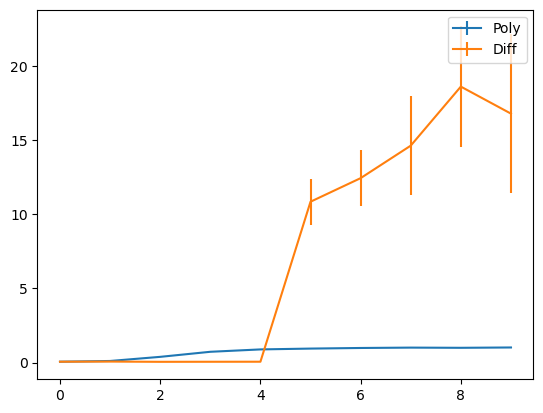

In [94]:
n = 400
base_problem = get_synthetic_problem(
    "test_function", 
    n=n, 
    seed=2,
    problem_kwargs={
        "log": False, 
        "random_graph_type": "grid",
        "m": 2,
        "n": n,
        "test_function": "sphere"
        }
    )

X_train = torch.empty(0,1)
Y_train = torch.empty(0,1)
base_model, base_mll, based_cached_eigenbasis = initialize_model(
                train_X=X_train,
                train_Y=Y_train,
                context_graph=base_problem.context_graph,
                covar_type="diffusion",
                covar_kwargs = {
                    "order": 1,
                     },
                fit_model=False,
                ard=True,
                use_fixed_noise=False,
                use_saas_map=False
                )

result = compute_test_result(base_problem, base_model, mc_samples=10, prop_data=0.5, n_eigenvalue=10)
result_mean_0, result_std_0 = result.mean(dim=0)[0], result.std(dim=0)[0]  
result_mean_1, result_std_1 = result.mean(dim=0)[1], result.std(dim=0)[1]  
plt.errorbar(x = range(result_mean_0.shape[0]), y = result_mean_0, yerr= result_std_0, label="Poly")
plt.errorbar(x = range(result_mean_1.shape[0]), y = result_mean_1, yerr= result_std_1, label="Diff")
plt.legend()

10it [03:26, 20.69s/it]


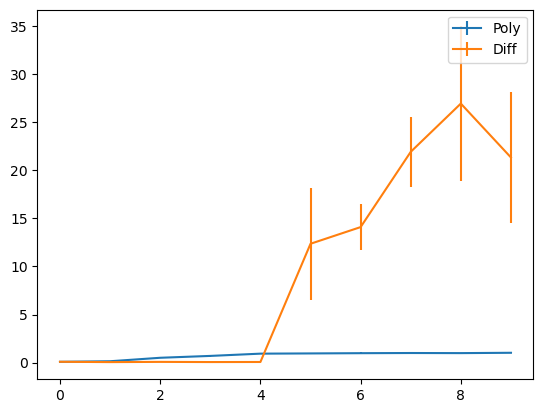

In [95]:
n = 400
base_problem = get_synthetic_problem(
    "test_function", 
    n=n, 
    seed=2,
    problem_kwargs={
        "log": False, 
        "random_graph_type": "ba",
        "m": 2,
        "n": n,
        "test_function": "sphere"
        }
    )

X_train = torch.empty(0,1)
Y_train = torch.empty(0,1)
base_model, base_mll, based_cached_eigenbasis = initialize_model(
                train_X=X_train,
                train_Y=Y_train,
                context_graph=base_problem.context_graph,
                covar_type="diffusion",
                covar_kwargs = {
                    "order": 1,
                     },
                fit_model=False,
                ard=True,
                use_fixed_noise=False,
                use_saas_map=False
                )

result = compute_test_result(base_problem, base_model, mc_samples=10, prop_data=0.5, n_eigenvalue=10)
result_mean_0, result_std_0 = result.mean(dim=0)[0], result.std(dim=0)[0]  
result_mean_1, result_std_1 = result.mean(dim=0)[1], result.std(dim=0)[1]  
plt.errorbar(x = range(result_mean_0.shape[0]), y = result_mean_0, yerr= result_std_0, label="Poly")
plt.errorbar(x = range(result_mean_1.shape[0]), y = result_mean_1, yerr= result_std_1, label="Diff")
plt.legend()

In [86]:
n = 400
base_problem = get_synthetic_problem(
    "test_function", 
    n=n, 
    seed=2,
    problem_kwargs={
        "log": False, 
        "random_graph_type": "ws",
        "m": 2,
        "p": 0.2,
        "k": 4,
        "test_function": "sphere"
        }
    )

X_train = torch.empty(0,1)
Y_train = torch.empty(0,1)
base_model, base_mll, based_cached_eigenbasis = initialize_model(
                train_X=X_train,
                train_Y=Y_train,
                context_graph=base_problem.context_graph,
                covar_type="diffusion",
                covar_kwargs = {
                    "order": 1,
                     },
                fit_model=False,
                ard=True,
                use_fixed_noise=False,
                use_saas_map=False
                )

result = compute_test_result(base_problem, base_model, mc_samples=10, prop_data=0.5, n_eigenvalue=10)
result_mean_0, result_std_0 = result.mean(dim=0)[0], result.std(dim=0)[0]  
result_mean_1, result_std_1 = result.mean(dim=0)[1], result.std(dim=0)[1]  
plt.errorbar(x = range(result_mean_0.shape[0]), y = result_mean_0, yerr= result_std_0, label="Poly")
plt.errorbar(x = range(result_mean_1.shape[0]), y = result_mean_1, yerr= result_std_1, label="Poly")
plt.legend()

0it [15:16, ?it/s]


KeyboardInterrupt: 

In [122]:
all_X = torch.arange(len(base_problem.context_graph)).to(torch.float)
all_Y = base_model.covar_module.base_kernel.eigenbasis[:,300].detach().clone()
from botorch.utils.transforms import standardize
n_init = len(all_X)
X = all_X.reshape(-1, 1).detach().clone()

# Y = base_problem(X.reshape(-1, 1))
Y = all_Y.reshape(-1, 1).to(dtype=torch.float).detach().clone()
Y = standardize(Y)

best_loc = Y.argmax().item()
X_best = X[best_loc]

n_train = int(n_init * 0.5)
ntrain_indices = np.random.choice(n_init, n_train, replace=False)
ntest_indices = np.array([i for i in range(n_init) if i not in ntrain_indices])
X_train, Y_train = X[ntrain_indices, ...], Y[ntrain_indices]
X_test, Y_test = X[ntest_indices, ...], Y[ntest_indices, ...]
criterion = torch.nn.MSELoss()

model_diff, mll_diff, cached_eigenbasis_diff = initialize_model(
            train_X=X_train,
            train_Y=Y_train,
            context_graph=base_problem.context_graph,
            covar_type="diffusion",
            covar_kwargs = {
                "order": len(base_problem.context_graph.nodes),
                },
            fit_model=True,
            ard=True,
            use_fixed_noise=False,
            optim_kwargs = {
                "train_iters": 500,
                "lr": 0.1
            },
            use_saas_map=False
            )

SignificanceResult(statistic=-0.05964526349856547, pvalue=0.40148531008563515)
Loss MSE tensor(203.9790)


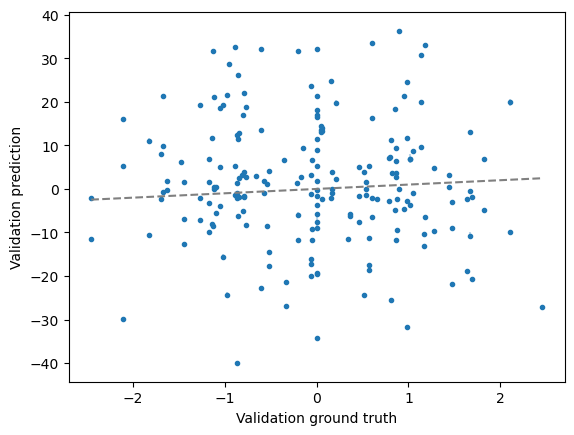

In [123]:
model_diff.eval()
with torch.no_grad():
    # predict on train input
    Y_test_pred = model_diff.posterior(X_test)
    lower, upper = Y_test_pred.mvn.confidence_region()

    Y_test_pred_mean, Y_test_pred_std = Y_test_pred.mean.flatten(), torch.sqrt(Y_test_pred.variance).flatten()
    plt.plot(Y_test, Y_test_pred_mean, ".")
    plt.errorbar(Y_test, Y_test_pred_mean, yerr=Y_test_pred_std, linestyle="None", color="C0", alpha=0.3)
    plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], color="gray", linestyle='--')
    print(spearmanr(Y_test_pred_mean, Y_test))
    plt.xlabel("Validation ground truth")
    plt.ylabel("Validation prediction")
    print("Loss MSE", torch.nn.MSELoss()(Y_test_pred_mean, Y_test))

Text(0.5, 1.0, 'GP training set')

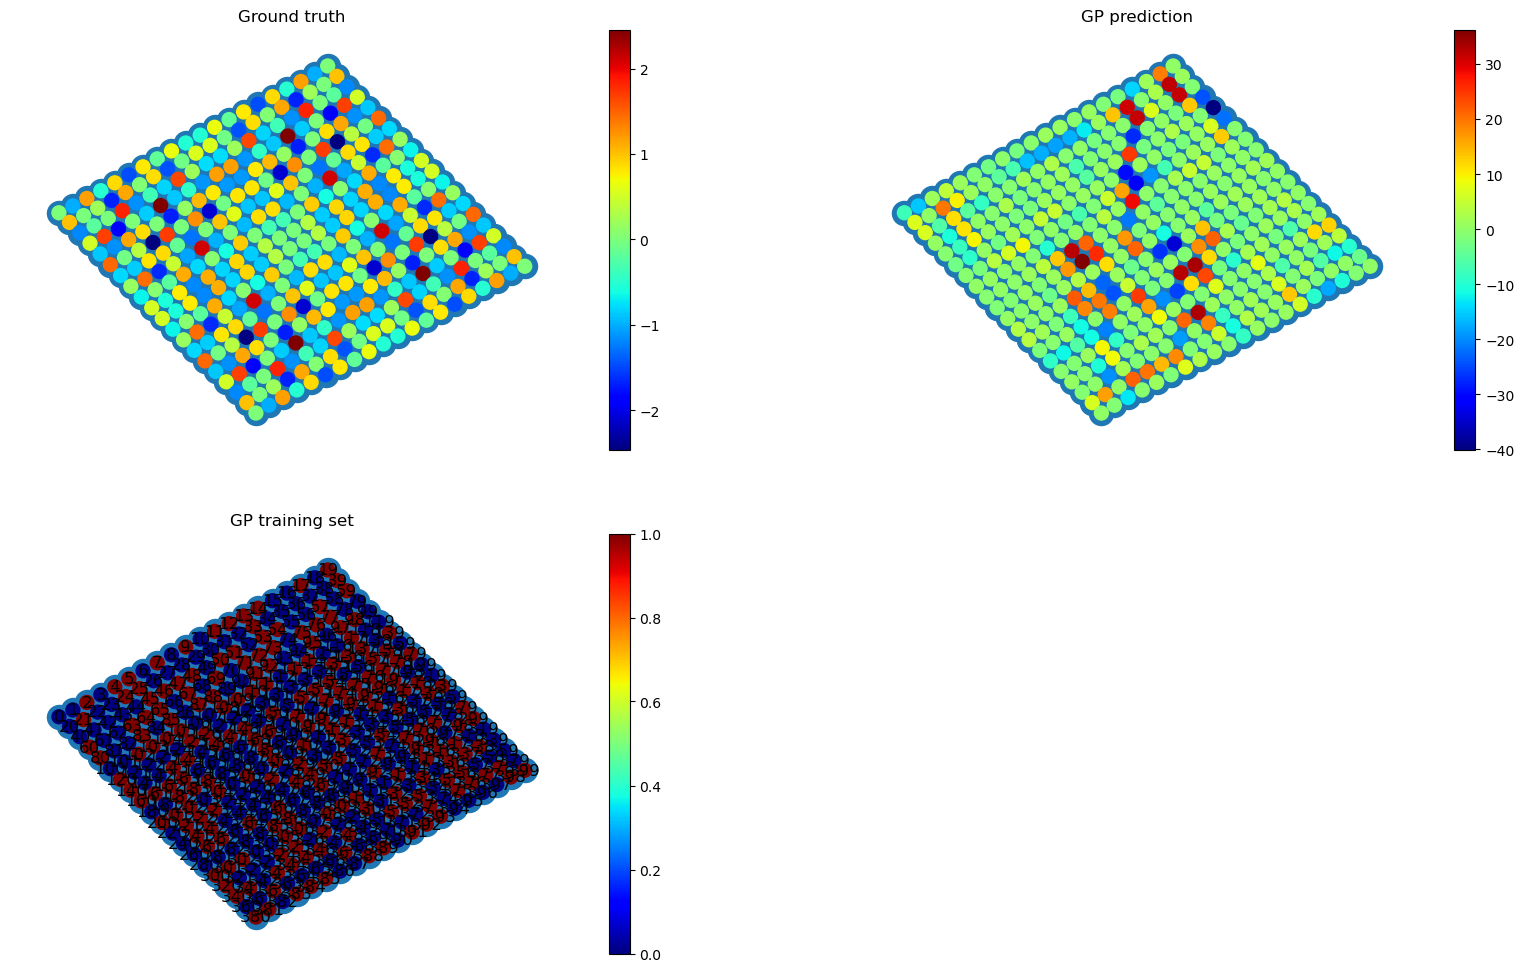

In [124]:
import networkx as nx
pos = nx.kamada_kawai_layout(base_problem.context_graph)
g = base_problem.context_graph
nodes = base_problem.context_graph.nodes()

train_X = X_train.long().flatten().tolist()
test_X = X_test.long().flatten().tolist()
train_Y = [all_Y[i] for i in train_X]
test_Y = [all_Y[i] for i in test_X]
train_pos = {k: pos[k] for k in train_X}
test_pos = {k: pos[k] for k in test_X}

plt.figure(figsize=[20, 12])
plt.subplot(221)
nx.draw_networkx(base_problem.context_graph, pos, with_labels=False)
ec = nx.draw_networkx_edges(g, pos, alpha=0.2)
c = nx.draw_networkx_nodes(g, pos, node_color=Y, node_size=100, cmap=plt.cm.jet, linewidths=None, edgecolors=None)

# nc = nx.draw_networkx_nodes(g, train_pos, nodelist=train_X, node_color="gray", node_size=50, cmap=plt.cm.jet, linewidths=0)
# nc = nx.draw_networkx_nodes(g, test_pos, nodelist=test_X, node_color=test_Y, node_size=25, linewidths=0)

plt.colorbar(c)
plt.axis('off')
plt.title("Ground truth")

plt.subplot(222)
with torch.no_grad():
    posterior =  model_diff.posterior(all_X.reshape(-1, 1))
    all_Y_pred =posterior.mean.flatten()
    all_Y_var =torch.sqrt(posterior.variance.flatten())

train_Y_pred = [all_Y_pred[i] for i in train_X]
test_Y_pred = [all_Y_pred[i] for i in test_X]

#colors = all_Y_pred.clip(all_Y.min(), all_Y.max())
colors = all_Y_pred
nx.draw_networkx(base_problem.context_graph, pos, with_labels=False)
ec = nx.draw_networkx_edges(g, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(g, pos, node_color=colors, node_size=100, cmap=plt.cm.jet, linewidths=None)

# nc = nx.draw_networkx_nodes(g, train_pos, nodelist=train_X, node_color="gray", node_size=50, cmap=plt.cm.jet, linewidths=0)
# nc = nx.draw_networkx_nodes(g, test_pos, nodelist=test_X, node_color=test_Y_pred, node_size=25, linewidths=0)
plt.colorbar(nc)
plt.axis('off')
plt.title("GP prediction")

plt.subplot(223)
bin_train = torch.tensor([1 if i in X_train else 0 for i in range(n)])
diff = torch.abs((all_Y_pred.flatten() - all_Y.flatten()) / all_Y.flatten())
# diff.clip_(0, 0.2)
nx.draw_networkx(base_problem.context_graph, pos,with_labels=True)
ec = nx.draw_networkx_edges(g, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(g, pos, node_color=bin_train, node_size=100, cmap=plt.cm.jet,)
plt.colorbar(nc)
plt.axis('off')
plt.title("GP training set")